This notebook describes how to fit a line using Tensorflow and Hamiltonion Monte Carlo Markov Chain using the Edward Package. 

We start by initializing some plotting parameters for later.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function, division

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

from matplotlib import pyplot
import corner

Imports needed below

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow.contrib.distributions import FULLY_REPARAMETERIZED

import edward
from edward.models import Normal, Uniform, Empirical

Generate some noisy synthetic data

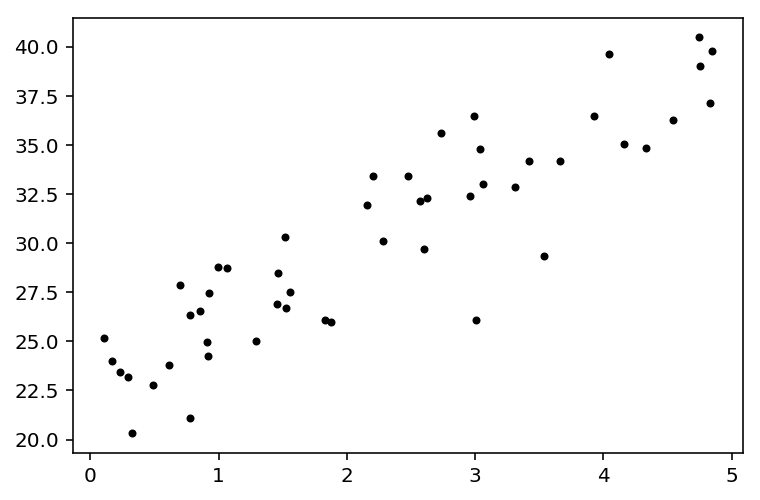

In [4]:
np.random.seed(42)

N = 50
x = np.sort(np.random.uniform(0, 5, N))
true_slope = 3.2
true_intercept = 23.0

y = true_slope * x + true_intercept
y += 2.5 * np.random.randn(N)

pyplot.plot(x, y, ".k");

Start by just using Tensorflow to fit the data using an optimizer. We first need to initialize our models so that Tensorflow knows what the shapes of the outputs will be.

In [5]:
x_tensor = tf.placeholder(tf.float32, (N,))
y_tensor = tf.placeholder(tf.float32, (N,))

# Params are slope, y-intercept, and log(scatter)
# Params are a vector so that the Hessian is calculated as a full matrix so that the covariances are included
params = tf.Variable(tf.ones(3, dtype=tf.float32))

model = params[0] * x_tensor + params[1]

negative_log_likelihood = 0.5 * tf.reduce_sum((y_tensor - model) ** 2 * tf.exp(-2 * params[2]) + 2.0 * params[2])

gradient = tf.gradients(negative_log_likelihood, params)

opt = tf.train.AdamOptimizer(0.1).minimize(negative_log_likelihood, var_list=params)

hessian = tf.hessians(negative_log_likelihood, params)

init = tf.global_variables_initializer()

Now we actually run the fit.

In [6]:
with tf.Session() as session:
    session.run(init)
    
    data = {x_tensor: x, y_tensor: y}
    nll_history = []
    for i in range(1000):
        session.run(opt, feed_dict=data)
        nll_history.append(session.run(negative_log_likelihood, feed_dict=data))
    
    hess_result = session.run(hessian, feed_dict=data)
    params_out = session.run(params)
    predicted = session.run(model, feed_dict=data)

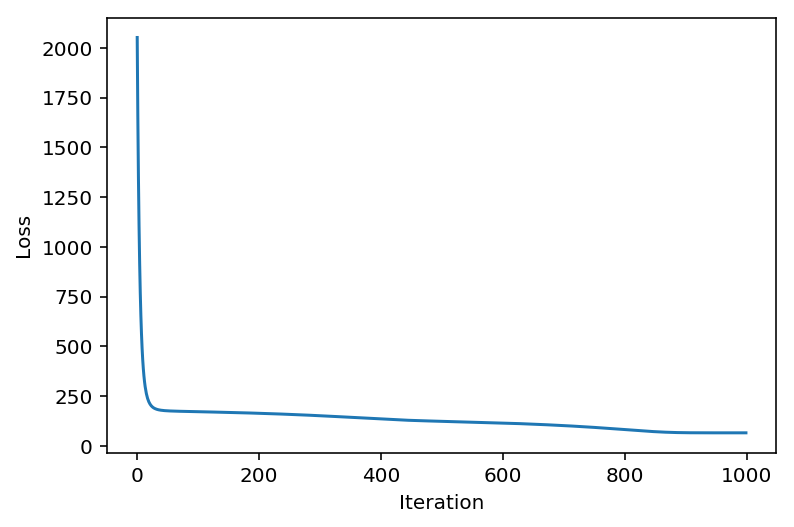

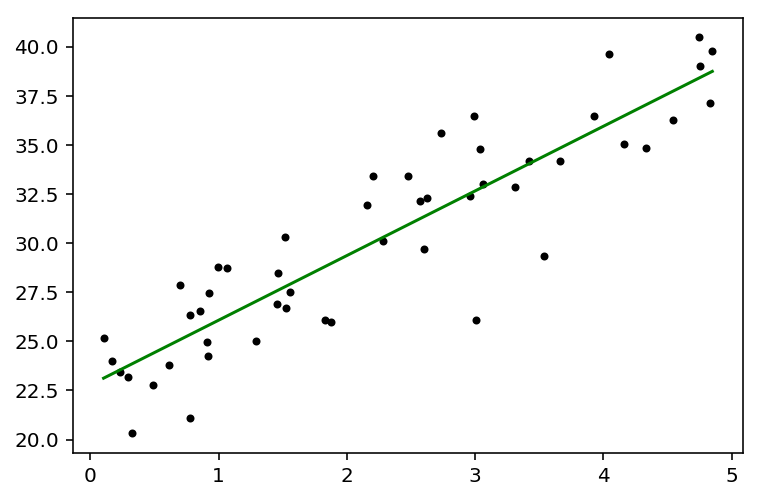

In [8]:
pyplot.plot(nll_history) 
pyplot.xlabel('Iteration'); pyplot.ylabel('Loss');
pyplot.figure()
pyplot.plot(x, y, ".k")
pyplot.plot(x, predicted, "g");

Next we do a basic fit using Edward following the tutorial.
We normalize the starting values to be the true input values from above and use Gaussian priors to make sure the fits converge.

In [47]:
X = tf.placeholder(tf.float32, N)
m = Normal(loc=tf.constant(3.2), scale=tf.constant(1.0))
b =  Normal(loc=tf.constant(23.), scale=tf.constant(1.0))
log_sigma = Normal(loc=tf.log(2.5), scale=tf.constant(1.0))
y_model = Normal(loc=m * X + b, scale=tf.exp(log_sigma))

We also assume the output distributions will be Gaussian for simplicity.

In [55]:
fit_m = Normal(loc=tf.Variable(tf.constant(3.2)), scale=tf.Variable(tf.constant(2.5)))
fit_b = Normal(loc=tf.Variable(tf.constant(23.0)), scale=tf.Variable(tf.constant(2.5)))
fit_log_sigma = Normal(loc=tf.Variable(tf.constant(2.5)), scale=tf.Variable(tf.constant(1.0)))

In [56]:
inference = edward.KLqp({m: fit_m, b: fit_b, log_sigma: fit_log_sigma}, {X: x, y_model: y})
inference.run(n_iter=500)

/usr/local/miniconda3/envs/tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 116.968


In [57]:
def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples).eval()
    b_samples = b.sample(n_samples).eval()
    pyplot.scatter(X_data, y_data, color='black')
    inputs = np.linspace(0, 6, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        pyplot.plot(inputs, output, 'r', alpha=0.1)

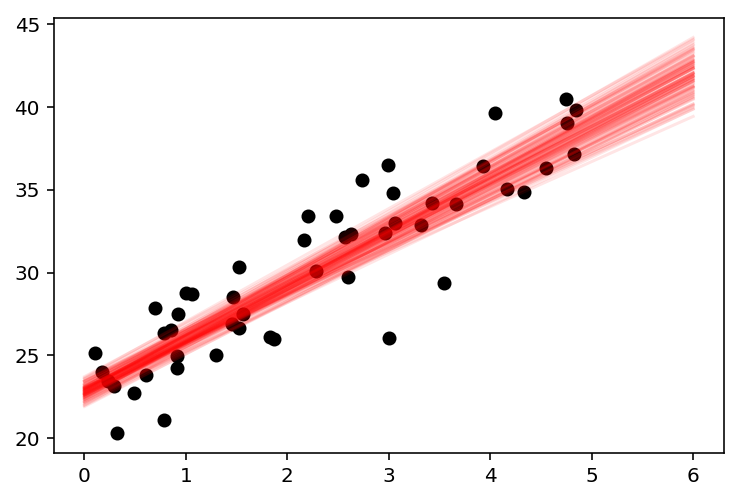

In [58]:
visualise(x, y, fit_m, fit_b, n_samples=100)

Next we fit using the Hamiltonian Monte Carlo (HMC) method. To do this we have to define our best-fit tensors as Empirical distributions. We start with 2000 iterations.

In [65]:
fit_m = Empirical(tf.Variable(3.2 * tf.ones(20000, dtype=tf.float32)))
fit_b = Empirical(tf.Variable(23 * tf.ones(20000, dtype=tf.float32)))
fit_log_sigma = Empirical(tf.Variable(2.5 * tf.ones(20000, dtype=tf.float32)))

In [66]:
inference = edward.HMC({m: fit_m, b: fit_b, log_sigma: fit_log_sigma}, {X: x, y_model: y})
inference.run()

/usr/local/miniconda3/envs/tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


20000/20000 [100%] ██████████████████████████████ Elapsed: 38s | Acceptance Rate: 0.021


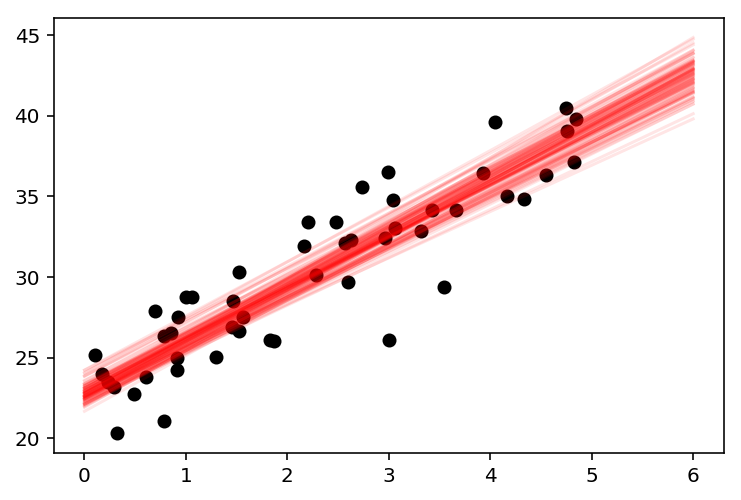

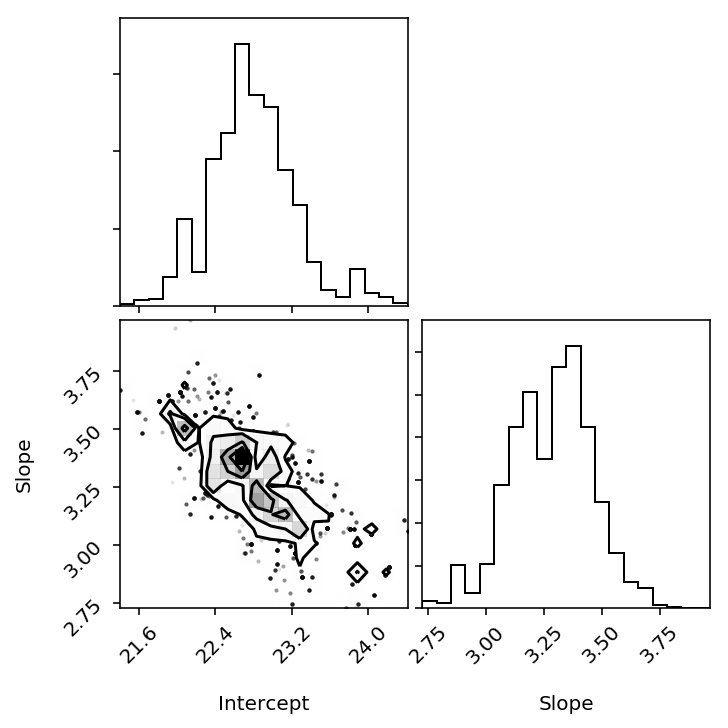

In [68]:
visualise(x, y, fit_m, fit_b, n_samples=100)
figure = corner.corner(np.vstack((fit_b.params.eval()[300:], fit_m.params.eval()[300:])).T, labels=['Intercept', 'Slope'])

Finally, we define a custom prior on the slopes. As per http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
a flat prior on the slope is not actually a non-informative prior. Instead one should use a flat prior in polar angle of the line. This yields a prior of $$p(m) = \frac{1}{2} (1 + \beta^2)^{-3/2}.$$
This distribution has a cdf given by $$CDF(m) = \frac{1}{2} (1 + \frac{m}{\sqrt{1 + m^2}}).$$
Transforming from a Uniform yields the following sampling formula: $$m = \frac{\sqrt{4 u - 4 u^2 - 1}}{2 \sqrt{u^2 - u}}$$ where u is a random variable drawn from a Uniform distribution. 

In [37]:
# Define a custom prior function that will give a flat distribution in angle for slopes
# see http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
# In mathematica: Integrate[a (1 + \[Beta]^2)^(-3/2), {\[Beta], -\[Infinity], \[Infinity]}]
# This yields a normalization factor of 1/2 
# The CDF is therefore:
# 1/2 (1 + x/Sqrt[1 + x^2])
# Therefore sampling (transforming from a uniform) is given by
# x -> Sqrt[-1 + 4 u - 4 u^2]/(2 Sqrt[-u + u^2])
from edward.models.random_variable import RandomVariable
from tensorflow.contrib.distributions import Distribution

# We have to start by defining a new Tensorflow distribution
class LineSlopes_Distribution(Distribution):
    def __init__(self, params, dtype=tf.float32, validate_args=False, allow_nan_stats=True, name="LineSlopes"):
        self.params = params
        super(LineSlopes_Distribution, self).__init__(dtype=dtype,
                                                      reparameterization_type=tf.contrib.distributions.FULLY_REPARAMETERIZED,
                                                      validate_args=validate_args,
                                                      allow_nan_stats=allow_nan_stats,
                                                      name=name)
    # These make sure we get the correct output shape.
    def _batch_shape(self):
        return self.params.get_shape()

    def _event_shape(self):
        return tf.constant(1).shape
    
    # The log of our prior
    def _log_prob(self, value):
        return -1.5 * tf.log(1.0 + value * value) - tf.log(2.0)
    
    # This is how you have to wrap numpy arrays to sample from the distribution of interest.
    def _sample_n(self, n=1, seed=None):
        def sample_slopes(n):
            np.random.seed(seed)
            u = np.random.uniform(0.0, 1.0, size=n)
            return (np.sqrt(4.0 * u - 4.0 * u * u - 1.0) / (2.0 * np.sqrt(-u + u * u))).astype(np.float32)
        # This is taken from http://edwardlib.org/api/model-development
        # wrap python function as tensorflow op
        val = tf.py_func(sample_slopes, [n], [tf.float32])[0]
        # set shape from unknown shape
        batch_event_shape = self.batch_shape.concatenate(self.event_shape)
        shape = tf.concat([tf.expand_dims(n, 0), tf.convert_to_tensor(batch_event_shape)], 0)
        val = tf.reshape(val, shape)
        return val

    
# This class actually implements the random variable.
class LineSlopes(RandomVariable, LineSlopes_Distribution):
    def __init__(self, *args, **kwargs):
        RandomVariable.__init__(self, *args, **kwargs)

In [38]:
X = tf.placeholder(tf.float32, N)
# Use our new prior
m = LineSlopes(tf.constant(3.2))
# This time use a uniform prior on the intercept.
b = Uniform(low=tf.constant(15.0), high=tf.constant(30.0))
y_model = Normal(loc=m * X + b, scale=2.5 * tf.ones(N, dtype=tf.float32))

In [39]:
fit_m = Empirical(tf.Variable(3.2 * tf.ones(2000, dtype=tf.float32)))
fit_b = Empirical(tf.Variable(23 * tf.ones(2000, dtype=tf.float32)))
fit_log_sigma = Empirical(tf.Variable(2.5 * tf.ones(2000, dtype=tf.float32)))

In [40]:
inference = edward.HMC({m: fit_m, b: fit_b, log_sigma: fit_log_sigma}, {X: x, y_model: y})
inference.run()

/usr/local/miniconda3/envs/tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


2000/2000 [100%] ██████████████████████████████ Elapsed: 6s | Acceptance Rate: 0.328


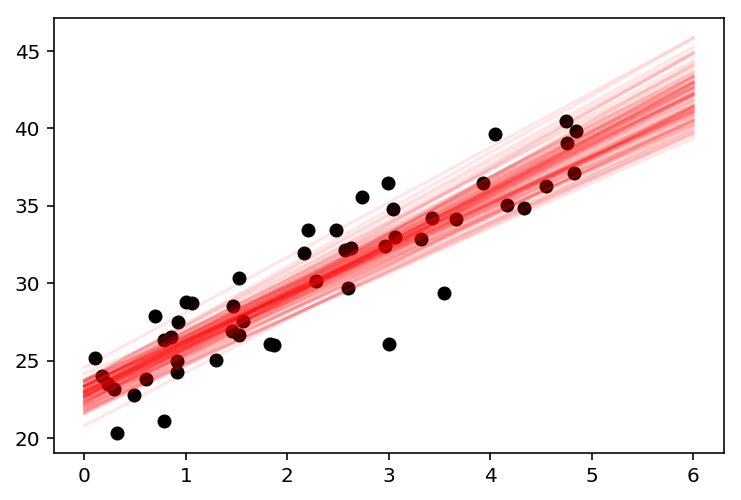

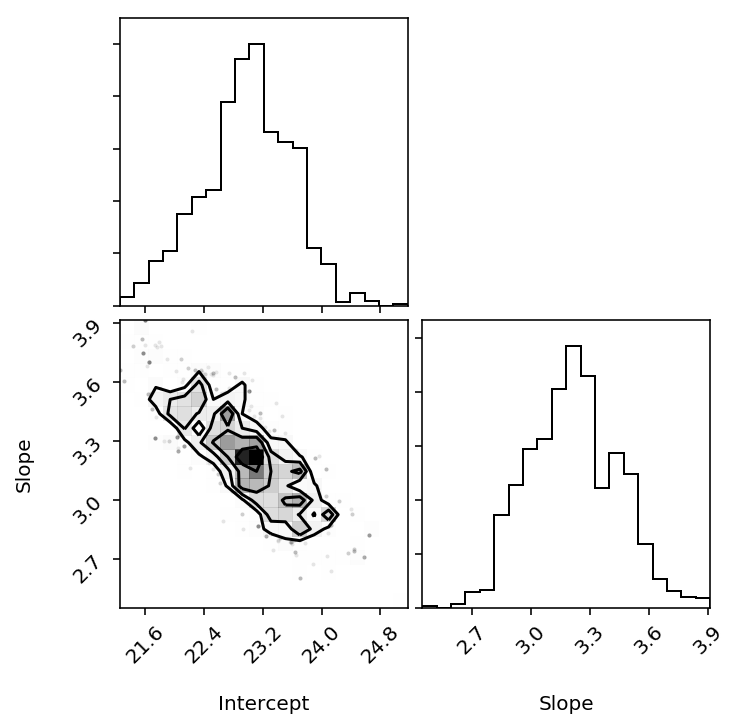

In [43]:
visualise(x, y, fit_m, fit_b, n_samples=100)
figure = corner.corner(np.vstack((fit_b.params.eval()[300:], fit_m.params.eval()[300:])).T, labels=['Intercept', 'Slope'])